## Partie II

In [13]:
%matplotlib inline  
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
import torchvision.datasets as datasets

In [14]:
train_data = datasets.FashionMNIST('./data-partie-2', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

valid_data = datasets.FashionMNIST('./data-partie-2', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [15]:
train_idx = np.random.choice(train_data.train_data.shape[0], 51000, replace=False)

C:\Users\Philippe\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [16]:
train_data.data = train_data.train_data[train_idx, :]
train_data.targets = train_data.train_labels[torch.from_numpy(train_idx).type(torch.LongTensor)]

C:\Users\Philippe\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [17]:
mask = np.ones(60000)
mask[train_idx] = 0

In [18]:
valid_data.data = valid_data.train_data[torch.from_numpy(np.argwhere(mask)), :].squeeze()
valid_data.targets = valid_data.train_labels[torch.from_numpy(mask).type(torch.ByteTensor)]

C:\w\1\s\tmp_conda_3.8_075429\conda\conda-bld\pytorch_1579852542185\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


In [19]:
len(train_data.data) 

51000

In [20]:
batch_size = 64
test_batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data-partie-2', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

## Architecture Fully Connected

In [21]:
class FcNN(nn.Module):
    def __init__(self, hidden_layers=[300], activation='relu'):
        super().__init__()
        self.type = "fully-connected"
        self.number_of_hidden_layers = len(hidden_layers)
        self.h_layer_nodes= hidden_layers[0]
        self.activation = activation
        self.fc1 = nn.Linear(28*28, self.h_layer_nodes)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_layers) - 1):
            self.hidden.append(nn.Linear(self.h_layer_nodes, self.h_layer_nodes))
        self.fc2 = nn.Linear(self.h_layer_nodes, 10)
    
    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        if self.activation == "sigmoid" :
            x = F.sigmoid(self.fc1(x))
            if self.number_of_hidden_layers > 0:
                for hidden_layer in self.hidden :
                     x = F.sigmoid(hidden_layer(x))
        elif self.activation == "relu":
            x = F.relu(self.fc1(x))
            if self.number_of_hidden_layers > 0:
               for hidden_layer in self.hidden :
                     x = F.relu(hidden_layer(x))
        elif self.activation == "tanh":
            x = F.tanh(self.fc1(x))
            if self.number_of_hidden_layers > 0:
               for hidden_layer in self.hidden :
                     x = F.tanh(hidden_layer(x))
                                   
        x = F.log_softmax(self.fc2(x), dim=1)
        return x
    

In [22]:
def train(model, train_loader, optimizer):
    criterion = F.nll_loss
    model.train()
    for batch_idx,(data, target) in enumerate(train_loader):
        data, target = Variable(data).cuda(), Variable(target).cuda()
        optimizer.zero_grad()
        output = model(data)  # calls the forward function
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    return model

def get_loss_and_accuracy(model, data_loader):
    criterion = F.nll_loss
    model.eval()
    loss = 0
    correct = 0
    for data, target in data_loader:
        data, target = Variable(data).cuda(), Variable(target).cuda()
        output = model(data)
        loss += criterion(output, target, reduction="sum").item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
    loss /= len(data_loader.dataset)
    return correct.item() / len(data_loader.dataset), loss 

def valid(model, valid_loader):
    precision, loss = get_loss_and_accuracy(model, valid_loader)
    print('\n' + "valid" + ' set: Average loss: {:.4f}, Accuracy: {:.3f} ({:.0f}%)\n'.format(
        loss, precision,
        100. * precision))
    return precision, loss


def test(model, test_loader, plot_title):
    print("Best Model is a : " + plot_title)
    precision, loss = get_loss_and_accuracy(model, test_loader)
    print('\n' + "test" + ' set: Average loss: {:.4f}, Accuracy: {:.3f} ({:.0f}%)\n'.format(
        loss, precision,
        100. * precision))
    return precision, loss

    
def experiment(model, plot_title, epochs_list=[10], lrs=[0.001]):
    best_precision = 0
    for lr in lrs:
        optimizer = optim.SGD(model.parameters(), lr=lr)
        for epochs in epochs_list:
            losses= []
            validation_accuracies = []
            for epoch in range(1, epochs + 1):
                model = train(model, train_loader, optimizer)
                train_precision, train_loss = get_loss_and_accuracy(model, train_loader)
                precision, valid_loss = valid(model, valid_loader)
                losses.append((train_loss,valid_loss))
                validation_accuracies.append((precision))
                if precision > best_precision:
                    best_precision = precision
                    best_model = model
                    best_lr = lr
                    best_epoch_num = epochs
            num_epoch_and_lr = "epochs={0} and lr={1}".format(epochs, lr)
            plotGraphs(losses, validation_accuracies, plot_title + num_epoch_and_lr, model.type)
            
    return best_model, best_precision, best_lr, best_epoch_num

def plotLoss(losses, plot_title, model_type):
    loss_type = "Negative log-likelihood"
    plt.title(loss_type + " loss of a " + plot_title)
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel(loss_type + " loss")
    plt.legend(['training', 'validation'], loc="upper right")
    plt.show()

def plotAccuracy(validation_accuracies, plot_title, model_type):
    plt.title("Accuracy of a " + plot_title)
    plt.plot(validation_accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['validation'], loc="lower right")
    plt.show()

def plotGraphs(losses, validation_accuracies, plot_title, model_type):
    plotLoss(losses, plot_title, model_type)
    plotAccuracy(validation_accuracies, plot_title, model_type)

In [23]:
from beautifultable import BeautifulTable  

Model with 2 hidden layers of size 300, with activation fonction relu 

valid set: Average loss: 0.5670, Accuracy: 0.804 (80%)


valid set: Average loss: 0.4722, Accuracy: 0.834 (83%)


valid set: Average loss: 0.4310, Accuracy: 0.850 (85%)


valid set: Average loss: 0.4126, Accuracy: 0.851 (85%)


valid set: Average loss: 0.3818, Accuracy: 0.863 (86%)


valid set: Average loss: 0.3773, Accuracy: 0.864 (86%)


valid set: Average loss: 0.3598, Accuracy: 0.870 (87%)


valid set: Average loss: 0.3555, Accuracy: 0.872 (87%)


valid set: Average loss: 0.3426, Accuracy: 0.878 (88%)


valid set: Average loss: 0.3479, Accuracy: 0.873 (87%)


valid set: Average loss: 0.3555, Accuracy: 0.873 (87%)


valid set: Average loss: 0.3296, Accuracy: 0.883 (88%)


valid set: Average loss: 0.3268, Accuracy: 0.883 (88%)


valid set: Average loss: 0.3184, Accuracy: 0.886 (89%)


valid set: Average loss: 0.3190, Accuracy: 0.886 (89%)


valid set: Average loss: 0.3174, Accuracy: 0.886 (89%)


valid set: Avera

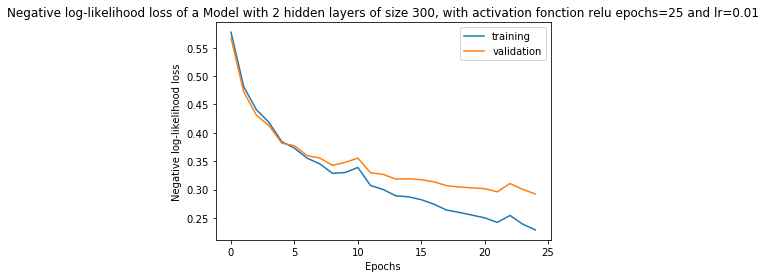

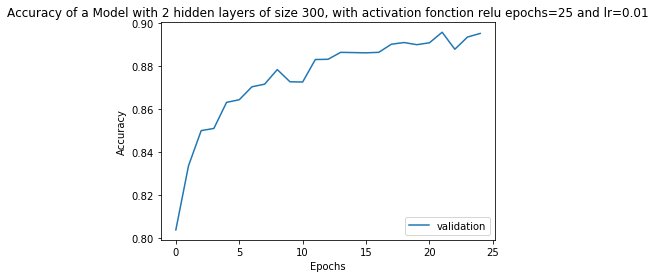

(0.8807, 0.3292097513198853)

In [24]:
##Meilleur modele
models =[FcNN([300,300], 'relu')]

# models = [FcNN([300,300], 'relu'),
#        FcNN([300,300], 'tanh'),
#        FcNN([300,300], 'sigmoid'),
#        FcNN([300], 'relu'),
#        FcNN([100, 100], 'relu'),
#        FcNN([800, 100], 'relu'),
#        FcNN([300, 300, 300], 'relu'),]

#lrs_to_try = [0.1, 0.01, 0.001]
lrs_to_try = [0.01]
#epochs_to_try = [10,25,50]
epochs_to_try = [25]
best_plot_title = ""
best_precision = 0
table = BeautifulTable()
table.column_headers = ["model", "lr", "epochs","valid_accuracy", "test_accuracy"]

for model in models:  # add your models in the list
    plot_title = "Model with {0} hidden layers of size {1}, with activation fonction {2} ".format(model.number_of_hidden_layers, model.h_layer_nodes, model.activation)
    print(plot_title)
    model.cuda()  # if you have access to a gpu
    model, precision, lr, epoch_num = experiment(model, plot_title, epochs_to_try, lrs_to_try)
    precision_test = test(model, test_loader, plot_title)
    table.append_row([plot_title, lr, epoch_num, precision, precision_test])
    if precision > best_precision:
        best_precision = precision
        best_model = model
        best_lr = lr
        best_epoch_num = epoch_num
        best_plot_title = plot_title
print(table)

test(best_model, test_loader, best_plot_title)

## Architecture CNN

In [25]:
class ConvNN(nn.Module):
    """Convnet Classifier"""
    def __init__(self, num_conv_layers, activation, dropout, pooling, conv_kernel, pool_kernel):
        super(ConvNN, self).__init__()
        self.type = "convolutional"
        self.activation = activation
        self.dropout = dropout
        self.pooling = pooling
        self.conv = nn.Sequential()
        self.conv_kernel = (conv_kernel,conv_kernel)
        self.pool_kernel = (pool_kernel, pool_kernel)
        self.channels_multiplier = 16
        last_dim = 0
        for i in range(1, num_conv_layers + 1):
            if i == 1:
                 in_channel = 1
            else:
                 in_channel = int(2**(2+i))
            out_channel = int(2**(3+i))
            
            self.conv.add_module("conv_" + str(i), nn.Conv2d(in_channel, out_channel, self.conv_kernel, padding=1))
            self.conv.add_module("dropout_" + str(i), torch.nn.Dropout(p=dropout))
            if activation == "relu":
                self.conv.add_module("relu_" + str(i), nn.ReLU())
            elif activation == "tanh":
                self.conv.add_module("tanh_" + str(i), nn.Tanh())
            if pooling == "max":
                self.conv.add_module("maxpool_" + str(i), torch.nn.MaxPool2d(kernel_size=self.pool_kernel, stride=2))
            elif pooling == "avg":
                self.conv.add_module("avgpool_" + str(i), torch.nn.AvgPool2d(kernel_size=self.pool_kernel, stride=2))
            last_dim = out_channel   
        self.clf = nn.Linear(last_dim, 10)
    def forward(self, x):
        x = self.conv(x).squeeze()
        x = self.clf(x)
        return F.log_softmax(x, dim=1)

Convolutional model, activation (relu) conv kernel((3, 3)) pooling (max) pooling kernel ((2, 2)) dropout (0.1) 

valid set: Average loss: 0.4323, Accuracy: 0.849 (85%)


valid set: Average loss: 0.3285, Accuracy: 0.882 (88%)


valid set: Average loss: 0.2946, Accuracy: 0.893 (89%)


valid set: Average loss: 0.3001, Accuracy: 0.891 (89%)


valid set: Average loss: 0.2735, Accuracy: 0.903 (90%)


valid set: Average loss: 0.2639, Accuracy: 0.905 (90%)


valid set: Average loss: 0.2452, Accuracy: 0.913 (91%)


valid set: Average loss: 0.2442, Accuracy: 0.906 (91%)


valid set: Average loss: 0.2358, Accuracy: 0.910 (91%)


valid set: Average loss: 0.2266, Accuracy: 0.918 (92%)

Best Model is a : Convolutional model, activation (relu) conv kernel((3, 3)) pooling (max) pooling kernel ((2, 2)) dropout (0.1) 

test set: Average loss: 0.2469, Accuracy: 0.910 (91%)

+-----------------------------------------+-----+---------+-------+------------+
|                  model                  | lr  | e

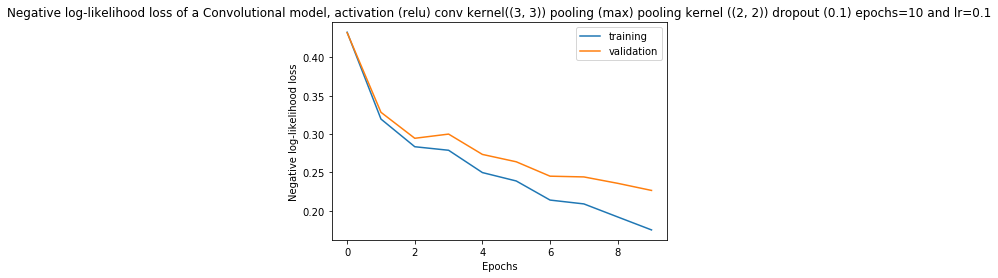

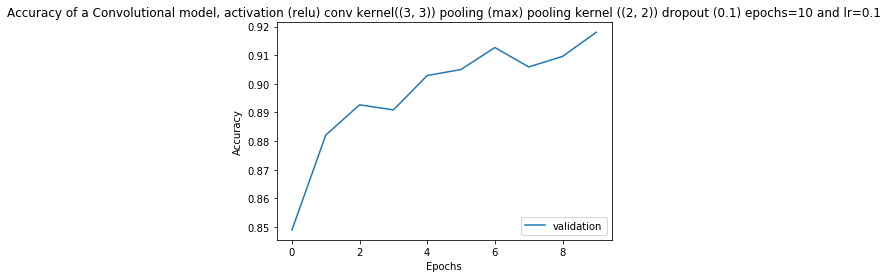

(0.9099, 0.24687521138191224)

In [26]:
##Meilleur modele
conv_models = [ConvNN(4, "relu", 0.1, "max",  3, 2)]

# conv_models = [ConvNN(4, "relu", 0.5, "avg",  3, 2),
#                ConvNN(4, "relu", 0.5, "max", 3, 2),
#                ConvNN(4, "tanh", 0.5, "max",  3, 2),
#                ConvNN(4, "sigmoid", 0.5, "max",  3, 2),
#                ConvNN(4, "relu", 0.9, "max", 3, 2),
#                ConvNN(4, "relu", 0.1, "max",  3, 2)]
#lrs_to_try = [0.1, 0.01, 0.001]
lrs_to_try = [0.1]
#lrs_to_try = [0.01]
epochs_to_try = [10]
#epochs_to_try = [10,25,50]

best_plot_title = ""
best_precision = 0
table = BeautifulTable()

table.column_headers = ["model", "lr", "epochs","valid_accuracy", "test_accuracy"]
for conv_model in conv_models:  # add your models in the list
    plot_title = "Convolutional model, activation ({0}) conv kernel({1}) pooling ({2}) pooling kernel ({3}) dropout ({4}) ".format( conv_model.activation, conv_model.conv_kernel,  conv_model.pooling, conv_model.pool_kernel, conv_model.dropout)
    print(plot_title)
    conv_model.cuda() 
    conv_model, precision, lr, epoch_num = experiment(conv_model, plot_title, epochs_to_try, lrs_to_try)
    precision_test = test(conv_model, test_loader, plot_title)
    table.append_row([plot_title, lr, epoch_num, precision, precision_test])
    if precision > best_precision:
        best_precision = precision
        best_model = conv_model
        best_lr = lr
        best_epoch_num = epoch_num
        best_plot_title = plot_title
print(table)

test(best_model, test_loader, best_plot_title)




